<a href="https://colab.research.google.com/github/anshulsawant/llms-11-667/blob/main/Grouped_Query_Attention_(GQA)_Coding_Activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Grouped Query Attention (GQA) Coding Activity**

In this activity, you'll complete one-line code snippets to implement key steps of Grouped Query Attention. This will help you understand the core concepts of GQA.


## **Background: Multi-head Attention**

Recall that multi-head attention is a key component of transformer models, allowing them to focus on different parts of the input sequence simultaneously. In multi-head attention, the input is linearly projected into multiple sets of query, key, and value vectors. Each set forms an "attention head," enabling the model to capture various aspects of the input in parallel. These heads independently compute attention scores and weighted sums, which are then concatenated and linearly transformed to produce the final output. This mechanism enhances the model's ability to capture complex relationships within the data by attending to different representation subspaces.

## **What is GQA?**

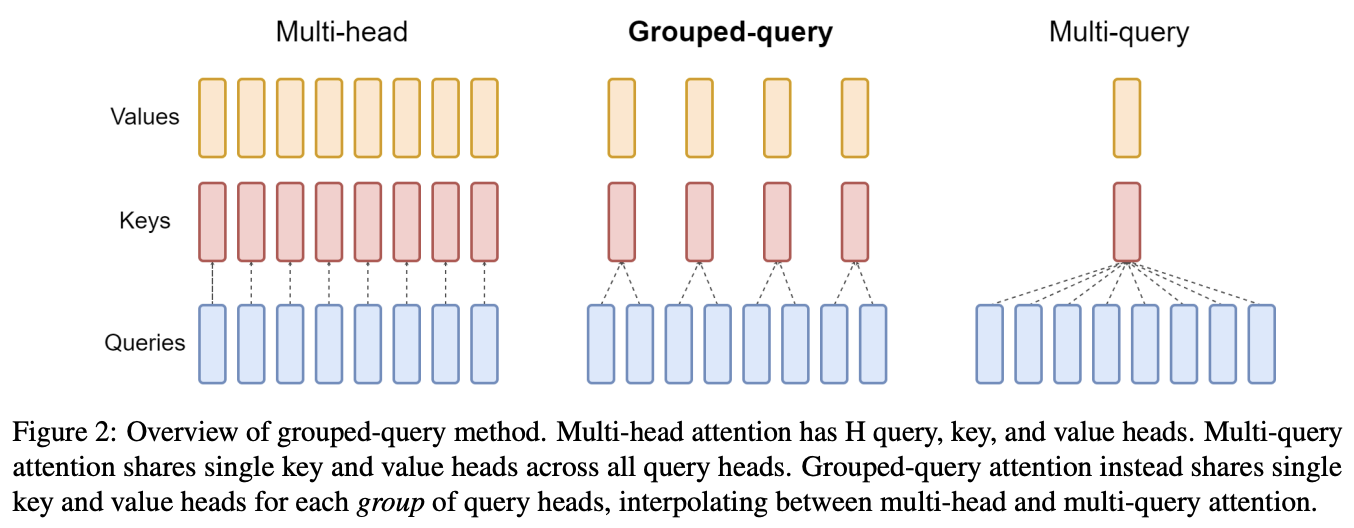

Paper: https://arxiv.org/pdf/2305.13245

GQA divides query heads into groups, with each group sharing a single key head and value head. This structure allows GQA to balance the trade-offs between model quality and inference speed. While MQA uses a single key-value head for all query heads, potentially sacrificing model capacity, and MHA uses separate key-value heads for each query head, leading to higher memory bandwidth requirements, GQA offers a flexible compromise. By using an intermediate number of key-value heads (more than one, but less than the total number of query heads), GQA achieves quality close to multi-head attention while maintaining speed comparable to multi-query attention. This approach is particularly beneficial for larger models, where it can provide a favorable balance between performance and computational efficiency.




## **Setup**

We will be using the `einops` library (https://einops.rocks/) for this exercise.
The einops library is a powerful tool for tensor manipulation, offering a more intuitive and readable way to perform complex operations like reshaping, transposing, and reducing tensors.

The `rearrange` function (https://einops.rocks/api/rearrange/) allows for flexible tensor restructuring using a pattern string. It can perform operations like transposing, reshaping, squeezing, unsqueezing, stacking, and concatenating.

The `einsum` function (https://einops.rocks/api/einsum/) implements Einstein summation convention with named axes, enabling tensor products and contractions.

First, let's set up our environment with the necessary imports and initial tensor shapes:

In [5]:
import torch
from einops import rearrange, einsum
import torch.nn.functional as F

# Shapes: (batch_size, seq_len, num_heads, head_dim)
query = torch.randn(1, 256, 8, 64)
key = torch.randn(1, 256, 2, 64)
value = torch.randn(1, 256, 2, 64)

We want to choose number of heads for key and value, such that `num_heads_for_query % num_heads_for_key = 0`

In [6]:
num_head_groups = query.shape[2] // key.shape[2]
print(f"Number of head groups: {num_head_groups}")

Number of head groups: 4


## **Task 1: Rearrange Dimensions**

Rearrange the dimensions of the query, key, and value tensors to swap `seq_len` and `num_heads`. We're moving the `num_heads` dimension (h) before the `seq_len` dimension (n or s) for efficient computation.

**Instructions:** Complete the following lines using the einops `rearrange` function:

b: batch size

n: query sequence length

s: key/value sequence length

h: number of attention heads

d: dimension of each head

In [7]:
query = rearrange(query, "b n h d -> b h n d")
key = rearrange(key, "b s h d -> b h s d")
value = rearrange(value, "b s h d -> b h s d")

**Solution:**

`query = rearrange(query, "b n h d -> b h n d")`

`key = rearrange(key, "b s h d -> b h s d")`

`value = rearrange(value, "b s h d -> b h s d")`

## **Task 2: Introduce Groups in Query**

Reshape the query tensor to split the head dimension into groups. The new shape will be (batch, groups, heads_per_group, seq_len, head_dim).

g: number of head groups

**Instructions:** Complete the following line using the `rearrange` function:

In [8]:
## There are hg queries. We want to split them into g groups of h queries each.
## This can be done without the transpose. Why is there g h transposition?
query = rearrange(query, "b (h g) n d -> b g h n d", g=num_head_groups)

**Solution:**

`query = rearrange(query, "b (h g) n d -> b g h n d", g=num_head_groups)`


## **Task 3: Compute Attention Scores**

Use the `einsum` function to compute attention scores. This performs matrix multiplication between query and key, then sums across the group dimension. The resulting shape is (batch, num_kv_heads, query_seq_len, key_seq_len).

**Instructions:** Complete the following line using the `einsum` function:

In [ ]:
scores = einsum(query, key, "b g h n d, b h s d -> ___")

**Solution:**

`scores = einsum(query, key, "b g h n d, b h s d -> b h n s")`

## **Task 4: Apply Softmax and Compute Output**

Apply softmax to the attention scores and compute the final output. We apply softmax to the scaled attention scores, then perform a weighted sum of the values based on the attention weights.

The einsum function performs two key operations:
Matrix Multiplication: It multiplies the query and key tensors along their last two dimensions. In this case, with query shaped (1, 4, 2, 256, 64) and key shaped (1, 2, 256, 64), the result is a tensor of shape (1, 4, 2, 256, 256).

Dimension Reduction: It then automatically sums across the second dimension (the 'g' or group dimension) because this dimension is not specified in the output shape. This summation is necessary to align the number of heads in the result with the number of heads in the keys and values.


**Instructions:** Complete the following lines:

In [ ]:
scale = query.size(-1) ** 0.5
attention = F.softmax(___, dim=-1)
out = einsum(attention, value, "b h n s, b h s d -> ___")

**Solution:**

`scale = query.size(-1) ** 0.5`

`attention = F.softmax(scores / scale, dim=-1)`

`out = einsum(attention, value, "b h n s, b h s d -> b h n d")`

## **Task 5: Final Reshape**

Reshape the output tensor to the original dimensions. This reshapes the output tensor back to the original dimension order: (batch, seq_len, num_kv_heads, head_dim).

**Instructions:** Complete the following line using the `rearrange` function:

In [ ]:
out = rearrange(out, "b h n d -> ___")

**Solution:**

`out = rearrange(out, "b h n d -> b n h d")`


That's it! Let's recap what you've learned:

1. You've implemented key steps of GQA using simple one-line code completions.

2. You've practiced using the rearrange and einsum functions from the einops library to manipulate tensors efficiently.

3. You've seen how GQA organizes queries into groups and shares key-value pairs among these groups.

4. You've implemented the core computations of attention mechanisms, including score calculation and weighted sum of values.

By working through these tasks, you've gained practical insight into how GQA operates and how it differs from standard multi-head attention. This understanding is crucial as GQA represents an important optimization in large language models, balancing computational efficiency with model performance.



# **Reference:**

[1] https://medium.com/@maxshapp/grouped-query-attention-gqa-explained-with-code-e56ee2a1df5a